In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
import numpy as np
import tensorflow as tf

## Fetching the Data 

This is a bit annoying. But to download from kaggle we need to upload the API key here. Then we need to move the file to the correct folder after which we need to change the permissions. The error messages will not provide helpful information. Then again, this code works;

In [0]:
# from google.colab import files
# files.upload()

In [0]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d therohk/million-headlines

 44% 9.00M/20.2M [00:00<00:00, 54.6MB/s]
100% 20.2M/20.2M [00:00<00:00, 80.4MB/s]


In [0]:
import pandas as pd
headlines = pd.read_csv('million-headlines.zip')['headline_text']

## Sequence of Letters 

Let's now take these headlines and grab sequences of letters out of them.

In [0]:
headlines[0]

'aba decides against community broadcasting licence'

In [0]:
import itertools as it 

def sliding_window(txt):
  for i in range(len(txt) - 2):
    yield txt[i], txt[i + 1], txt[i + 2]

window = list(it.chain(*[sliding_window(_) for _ in headlines[:10000]]))

In [0]:
mapping = {c: i for i, c in enumerate(pd.DataFrame(window)[0].unique())}
integers_in = np.array([[mapping[w[0]], mapping[w[1]]] for w in window])
integers_out = np.array([mapping[w[2]] for w in window]).reshape(-1, 1)

In [0]:
integers_in.shape

(376880, 2)

In [0]:
from tensorflow.keras.layers import Embedding, Dense, Flatten
from tensorflow.keras.models import Sequential

num_letters = len(mapping) # typically 36 -> 26 letters + 10 numbers

# this one is so we might grab the embeddings
model_emb = Sequential()
embedding = Embedding(num_letters, 2, input_length=2)
model_emb.add(embedding)
output_array = model_emb.predict(integers_in)
output_array.shape

(376880, 2, 2)

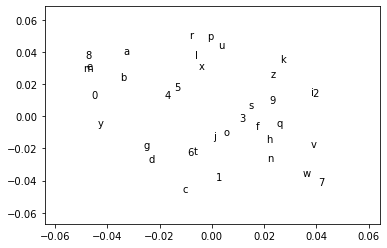

In [0]:
import matplotlib.pylab as plt

idx_to_calc = list(mapping.values())
idx_to_calc = np.array([idx_to_calc, idx_to_calc]).T

translator = {v:k for k,v in mapping.items()}
preds = model_emb.predict(idx_to_calc)

plt.scatter(preds[:, 0, 0], preds[:, 0, 1], alpha=0)
for i, idx in enumerate(idx_to_calc):
  plt.text(preds[i, 0, 0], preds[i, 0, 1], translator[idx[0]])

In [0]:
from tensorflow.keras.optimizers import Adam

# this one is so we might learn the mapping
model_pred = Sequential()
model_pred.add(embedding)
model_pred.add(Flatten())
model_pred.add(Dense(num_letters, activation="softmax"))

adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

model_pred.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

output_array = model_pred.predict(integers_in)
output_array.shape

(376880, 37)

In [0]:
from sklearn.preprocessing import OneHotEncoder

to_predict = OneHotEncoder(sparse=False).fit_transform(integers_out)
model_pred.fit(integers_in, to_predict, epochs=30, verbose=1)

Train on 376880 samples
Epoch 1/30
376880/376880 [==============================] - 20s 53us/sample - loss: 2.6621 - accuracy: 0.2179
Epoch 2/30
376880/376880 [==============================] - 20s 53us/sample - loss: 2.5821 - accuracy: 0.2296
Epoch 3/30
376880/376880 [==============================] - 20s 52us/sample - loss: 2.5776 - accuracy: 0.2294
Epoch 4/30
376880/376880 [==============================] - 20s 52us/sample - loss: 2.5756 - accuracy: 0.2296
Epoch 5/30
376880/376880 [==============================] - 20s 52us/sample - loss: 2.5743 - accuracy: 0.2297
Epoch 6/30
376880/376880 [==============================] - 20s 52us/sample - loss: 2.5729 - accuracy: 0.2292
Epoch 7/30
376880/376880 [==============================] - 20s 52us/sample - loss: 2.5714 - accuracy: 0.2299
Epoch 8/30
376880/376880 [==============================] - 20s 53us/sample - loss: 2.5703 - accuracy: 0.2300
Epoch 9/30
376880/376880 [==============================] - 20s 52us/sample - loss: 2.5694 - acc

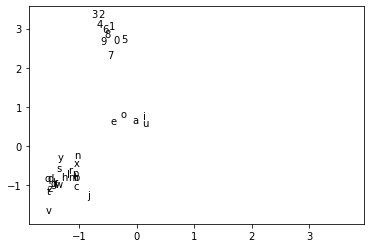

In [0]:
preds = model_emb.predict(idx_to_calc)
plt.scatter(preds[:, 0, 0], preds[:, 0, 1], alpha=0)
for i, idx in enumerate(idx_to_calc):
  plt.text(preds[i, 0, 0], preds[i, 0, 1], translator[idx[0]])